R-Squared: 0.9364678227857419
Adjusted R-Squared: 0.9241712723571759


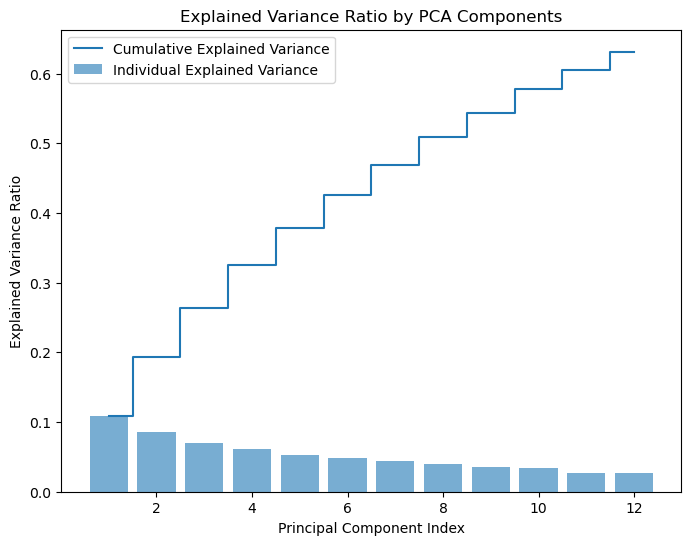

In [37]:
#Linear Regression model
# PROBLEM: 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv").iloc[:, 1:]

# Handle 'Gender' and encode categorical features
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df = pd.get_dummies(df, columns=['Occupation', 'BMI Category', 'Blood Pressure', 'Sleep Disorder'], drop_first=True)

# Define features and target
X = df.drop(columns=['Quality of Sleep'])
y = df['Quality of Sleep']

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply PCA on the training data
pca = PCA(n_components=12)
X_train_pca = pca.fit_transform(X_train_scaled)

# Transform the test data using the same scaler and PCA objects
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

# X_train_pca and X_test_pca for training and testing your model
model = LinearRegression()
model.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_pca)

# Calculate R-squared and Adjusted R-squared for the test set
r2 = r2_score(y_test, y_pred)
adjusted_r2 = 1 - (1-r2) * (len(y_test)-1) / (len(y_test)-X_train_pca.shape[1]-1)

print(f'R-Squared: {r2}')
print(f'Adjusted R-Squared: {adjusted_r2}')

# Explained variance ratio for PCA components
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the explained variance
plt.figure(figsize=(8, 6))
plt.bar(range(1, 13), explained_variance_ratio, alpha=0.6, label='Individual Explained Variance')
plt.step(range(1, 13), cumulative_explained_variance, where='mid', label='Cumulative Explained Variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component Index')
plt.legend(loc='best')
plt.title('Explained Variance Ratio by PCA Components')
plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.5s finished


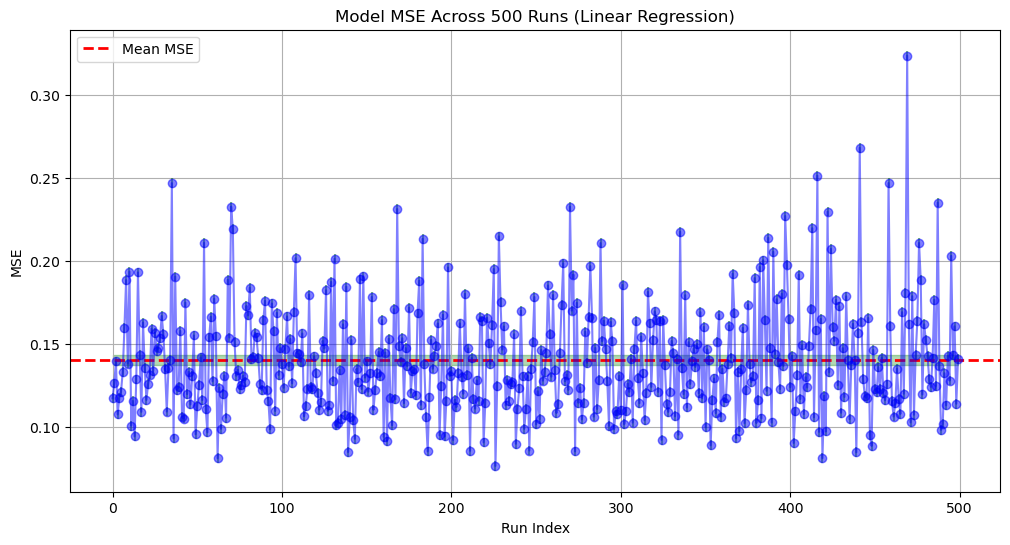

Mean MSE: 0.14038637375904034


In [38]:
from joblib import Parallel, delayed
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def train_and_evaluate_model(seed):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)
    
    # Standardize the training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Apply PCA on the scaled training data
    pca = PCA(n_components=10)
    X_train_pca = pca.fit_transform(X_train_scaled)
    
    # Transform the test data
    X_test_scaled = scaler.transform(X_test)
    X_test_pca = pca.transform(X_test_scaled)

    # Initialize and train the model on PCA data
    model = LinearRegression()
    model.fit(X_train_pca, y_train)

    # Make predictions
    y_pred = model.predict(X_test_pca)

    # Calculate MSE on the PCA-transformed test set
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Runs
n_runs = 500 
results = Parallel(n_jobs=-1, verbose=1)(
    delayed(train_and_evaluate_model)(seed) for seed in range(n_runs)
)

# Convert results to array
results_array = np.array(results)

# Calculate mean MSE and standard deviation
mean_mse = np.mean(results_array)
std_deviation = np.std(results_array)
margin_of_error = 1.96 * (std_deviation / np.sqrt(n_runs))

# Plot the mean MSE with confidence interval using error bars
plt.figure(figsize=(12, 6))
plt.errorbar(indices, results_array, yerr=margin_of_error, fmt='o', linestyle='-', color='b', ecolor='g', alpha=0.5)
plt.fill_between(indices, mean_mse - margin_of_error, mean_mse + margin_of_error, color='g', alpha=0.3)
plt.axhline(mean_mse, color='red', linestyle='dashed', linewidth=2, label='Mean MSE')
plt.xlabel('Run Index')
plt.ylabel('MSE')
plt.title(f'Model MSE Across {n_runs} Runs (Linear Regression)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean MSE: {mean_mse}")